In [1]:
import sys
sys.path.append('../..')
from src.pomdp import *

import cv2
import os
import h5py
import sys
import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [2]:
from cupy.cuda import runtime as cuda_runtime
cuda_runtime.setDevice(3)

# Sea Robins Real Simulation

## Data Exploration

### Example from Martin 

#### README

Each file contain two slices of the simulated 2d odor field (along the horizontal plane) in the experimental chamber of the sea robin tank. The different files are for multiple positions o
f the odor source.

Data directories:

- file 'odor_source_15_15.h5': /storage/james/2024_05_19_b... in e4-seminara server
- file 'odor_source_15_45.h5': /storage/james/2024_05_19_a... in e4-seminara server
- file 'odor_source_55_45.h5': /storage/james/2024_05_19_c... in e4-seminara server
- file 'odor_source_55_15.h5': /storage/james/2024_05_19_d... in e4-seminara server

Check read_h5.py for data format. (for data at (X, Y) --> odor[(Y/90)*408, (X/110)*488]

Tank dimensions: 110 x 90 x 18 (datasets are of horizontal slices 110 x 90)
Grid: 488 x 408 x 90 (datasets are of 488 x 408)

dataset 'odor_base' is the odor field close to the bottom surface
dataset 'odor_middle' is the odor field at Z = 6

odor source location:

- file 'odor_source_15_15.h5': X = 15, Y = 15
- file 'odor_source_15_45.h5': X = 15, Y = 45
- file 'odor_source_55_45.h5': X = 55, Y = 45
- file 'odor_source_55_15.h5': X = 55, Y = 15

total number of snapshots = 600
delta time between snapshots = 1 second
input jet velocity = 5 cm/s (at position 20 cm away from experimental jet, which has velocity 85 cm/s)

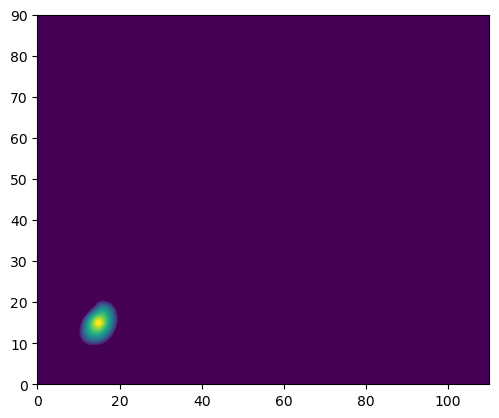

In [3]:
# followong script shows how to load the datasets in the hdf5 files
# and plot the corresponding odor field
# the first commandline argumet is the hdf5 filename
# the second commandline argument is the dataset to load ('odor_base' or 'odor_middle')
# the third commandline argument is the snapshot number (corresponds to seconds in real world data)

folder_name = '/storage/arnaud/sea_robin_tank_odor_data/'
ds = 'odor_base'
snapshot = '100'

data=h5py.File(folder_name + 'odor_source_15_15.h5','r')

# loads the odor field corresponding to the height and the snapshot number
odor=data[ds][snapshot]

# converts to numpy array
odor=np.array(odor)

# to plot the odor field in the logscale, let's first define the threshold
threshold = -4.0
odor[odor<=10**threshold] = 10**(-20)
plt.imshow(np.log10(odor),origin='lower',vmin=threshold,vmax=0,interpolation='bilinear',extent=(0,110,0,90),cmap='viridis',alpha=1)
plt.show()
# plt.savefig(sys.argv[2]+sys.argv[3]+".png") # saves the figure in the current directory

### Summary

In [4]:
files = [folder_name + f for f in os.listdir('/storage/arnaud/sea_robin_tank_odor_data') if f.endswith('.h5')]
files_source_positions = {}

for f in files:
    files_source_positions[f] = np.array([int(part) for part in f.removesuffix('.h5').split('_')[-2:]])

print(f'Found {len(files_source_positions)} files...')

Found 4 files...


In [5]:
files_source_positions

{'odor_source_15_15.h5': array([15, 15]),
 'odor_source_55_45.h5': array([55, 45]),
 'odor_source_15_45.h5': array([15, 45]),
 'odor_source_55_15.h5': array([55, 15])}

In [6]:
data_shape = odor.shape
timesteps = 600
file_datasets = {'ground': 'odor_base', 'air': 'odor_middle'}

print(f'Files data shape: {len(file_datasets)} x {timesteps} x {data_shape}')

Files data shape: 2 x 600 x (408, 488)


### Visualize source positions

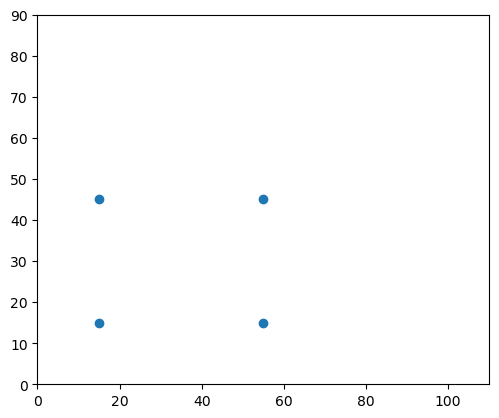

In [7]:
plt.imshow(np.zeros(data_shape), cmap='Greys',interpolation='bilinear',extent=(0,110,0,90))
source_points = np.array([*files_source_positions.values()])
plt.scatter(source_points[:,0], source_points[:,1])

### Reshaping to one walking step per second

A walking step is 0.8 cm/s so we can divide the environment shape by 0.8 to allow a walking step to correspond to a single grid unit.

In [8]:
data_shape

(408, 488)

In [9]:
real_shape_cm = {90, 110}

In [10]:
walking_speed = 0.8 # cm/s 

In [11]:
resized_shape = (np.array([*real_shape_cm]) / walking_speed).astype(int)

In [12]:
resized_files_source_positions = {
    file: (position / walking_speed).astype(int)
    for file, position in files_source_positions.items()
}

#### Example plot

In [13]:
resized_source_pos = (np.array([15,15]) / walking_speed).astype(int)

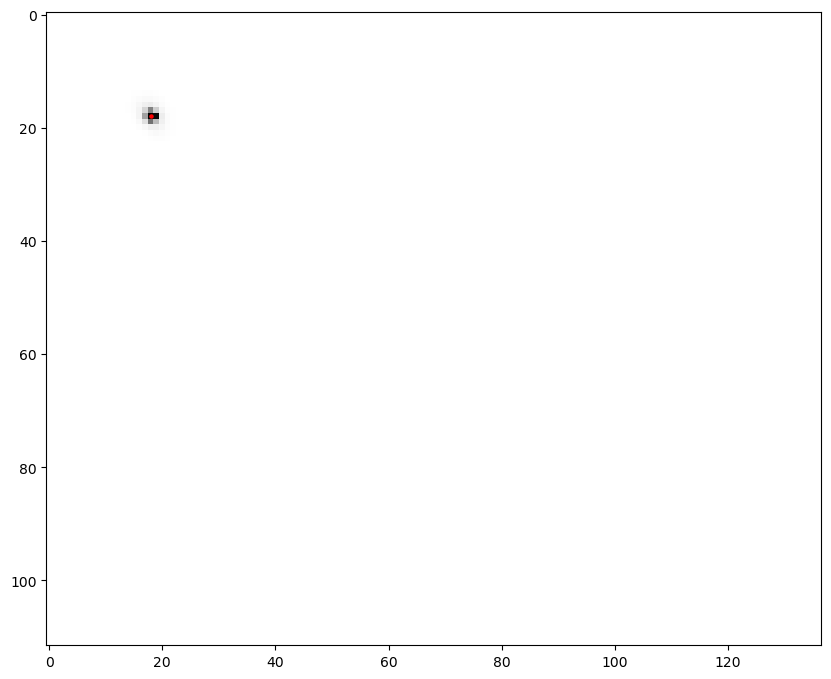

In [14]:
plt.figure(figsize=(10,10))
plt.imshow(cv2.resize(odor, resized_shape[::-1]), cmap='Greys')
plt.scatter(resized_source_pos[1], resized_source_pos[0], c='red', s=5)

### Visualize dataset averages

In [16]:
threshold = 1e-3
file_averages = {}

for file in tqdm(files):
    file_datasets_averages = {}
    for dataset_key, dataset_name in file_datasets.items():

        data=h5py.File(file,'r')
        average = np.zeros(resized_shape)

        for frame in range(timesteps):
            data_frame = np.array(data[dataset_name][str(frame)])

            resized_data_frame = cv2.resize(data_frame, resized_shape[::-1])

            average += (resized_data_frame > threshold).astype(int)

        average /= timesteps

        file_datasets_averages[dataset_key] = average
    
    file_averages[file] = file_datasets_averages

  0%|          | 0/4 [00:00<?, ?it/s]

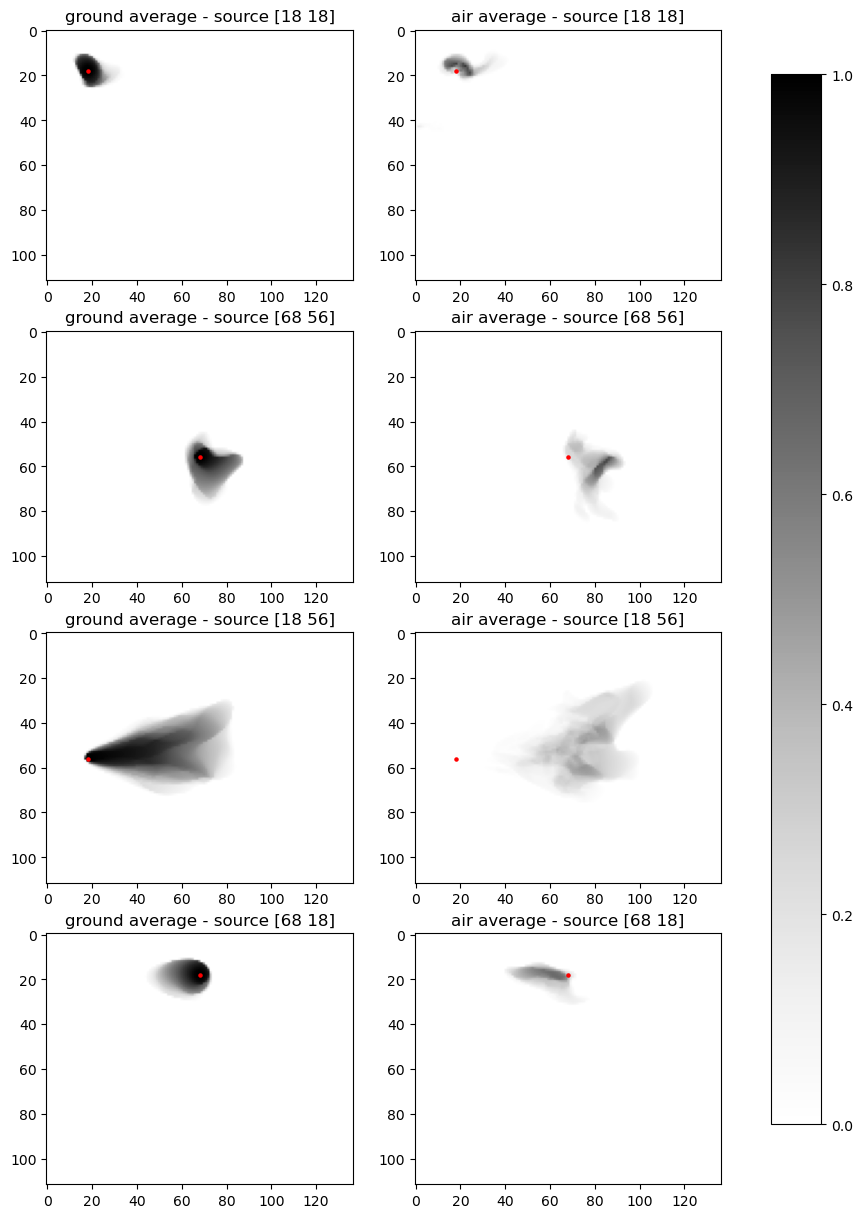

In [17]:
fig, axes = plt.subplots(nrows=len(files),
                         ncols=len(file_datasets),
                         figsize=(10,15))


for file_i, file in enumerate(files):
    source_position = resized_files_source_positions[file]
    for ds_i, ds in enumerate(file_datasets.keys()):
        ax:plt.Axes = axes[file_i, ds_i]
        ax.set_title(f'{ds} average - source {source_position}')
        im = ax.imshow(file_averages[file][ds], cmap='Greys', vmin=0, vmax=1)
        ax.scatter(source_position[0], source_position[1], c='red', s=5)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

## Model Definition

In [18]:
file_used = files[0]

In [19]:
env_shape = (resized_shape * 2) + 1
env_shape

array([225, 275])

In [20]:
source_position = files_source_positions[file_used]

In [21]:
walking_moves = [
    np.array([1 , 0]),
    np.array([0 , 1]),
    np.array([-1, 0]),
    np.array([0 ,-1]),
]

In [22]:
# Moves
rad = 8.5
center = np.array([0,0])
moves = []

for r in [0,4]:
# for r in range(int(np.floor(rad * np.sqrt(0.5)))):
    d = int(np.floor(np.sqrt(rad**2 - r**2)))
    moves.append(center + np.array([-d,  r]))
    moves.append(center + np.array([ d,  r]))
    moves.append(center + np.array([-d, -r]))
    moves.append(center + np.array([ d, -r]))
    moves.append(center + np.array([ r, -d]))
    moves.append(center + np.array([ r,  d]))
    moves.append(center + np.array([-r, -d]))
    moves.append(center + np.array([-r,  d]))

u_moves = list({m.tobytes():m for m in moves}.values())

In [23]:
all_moves = walking_moves + u_moves

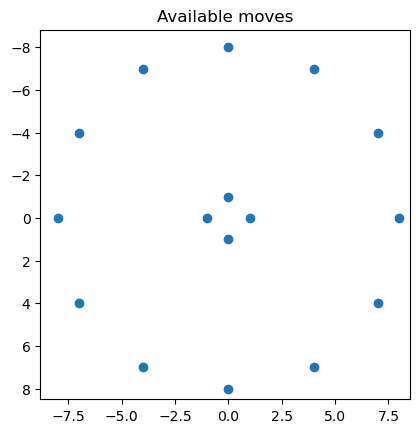

In [24]:
# Swimming steps
plt.title('Available moves')
plt.imshow(np.zeros((9,9)), cmap='Greys')
plt.scatter(np.array(all_moves)[:,0], np.array(all_moves)[:,1])

In [25]:
### POMDP states definition
state_grid = []  # this is a list of My lists of Mx strings (state labels) each
# State labels
for i in range(env_shape[0]): # My
    i_states = []
    for j in range(env_shape[1]): # Mx
        i_states.append(f's_{i}_{j}') # s_yind_xind
    state_grid.append(i_states)
state_count = int(np.prod(env_shape))

In [26]:
reachable_states = np.full(shape=(state_count, len(all_moves)), fill_value=-1)

for x in range(env_shape[0]):
    for y in range(env_shape[1]):
        for a, m in enumerate(all_moves):
            pos = np.array([x,y])
            m = np.array(m)

            new_pos = pos + m

            # Handle border for new pos
            new_pos = new_pos % np.array(env_shape)
            new_pos[0] = new_pos[0] + env_shape[0] if new_pos[0] < 0 else new_pos[0]
            new_pos[1] = new_pos[1] + env_shape[1] if new_pos[1] < 0 else new_pos[1]

            # Flatten pos
            flat_pos = (env_shape[1] * pos[0]) + pos[1]
            flat_new_pos = (env_shape[1] * new_pos[0]) + new_pos[1]
            reachable_states[flat_pos, a] = flat_new_pos

reachable_states = reachable_states[:,:,None]

In [27]:
walking_obs_likelihood = np.zeros(env_shape)
walking_obs_likelihood[(resized_shape[0]-source_position[0]):(env_shape[0]-source_position[0]-1), (resized_shape[1]-source_position[1]):(env_shape[1]-source_position[1]-1)] = file_averages[files[0]]['ground']

swimming_obs_likelihood = np.zeros(env_shape)
swimming_obs_likelihood[(resized_shape[0]-source_position[0]):(env_shape[0]-source_position[0]-1), (resized_shape[1]-source_position[1]):(env_shape[1]-source_position[1]-1)] = file_averages[files[0]]['air']

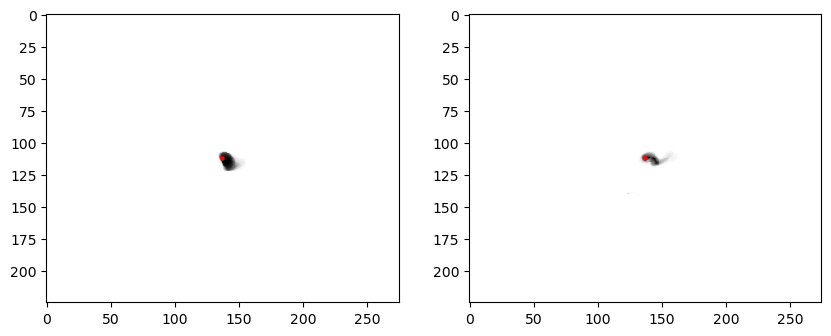

In [28]:
_, axes = plt.subplots(1, 2, figsize=(10,5))

axes[0].imshow(walking_obs_likelihood, cmap='Greys')
axes[0].scatter(resized_shape[1], resized_shape[0], c='red', s=5)

axes[1].imshow(swimming_obs_likelihood, cmap='Greys')
axes[1].scatter(resized_shape[1], resized_shape[0], c='red', s=5)

In [29]:
observation_walking = np.concatenate((walking_obs_likelihood.flatten()[:,None], (1-walking_obs_likelihood.flatten()[:,None])),axis=1)
observation_swimming = np.concatenate((swimming_obs_likelihood.flatten()[:,None], (1-swimming_obs_likelihood.flatten()[:,None])),axis=1)
observations = np.hstack([observation_walking[:,None,:].repeat(len(walking_moves),axis=1), observation_swimming[:,None,:].repeat(len(u_moves), axis=1)])

In [30]:
# Check if goal observation improves things
model = Model(
    states=state_grid,
    actions=all_moves,
    observations=['something', 'nothing'],
    reachable_states=reachable_states,
    observation_table=observations,
    end_states=[(env_shape[1]*(env_shape[0]-1)/2 + (env_shape[1]-1)/2)]
    )

[06/05/2024, 13:16:25] Instantiation of MDP Model:
[06/05/2024, 13:16:25] - 61875 states
[06/05/2024, 13:16:25] - 16 actions
[06/05/2024, 13:16:25] - At most 1 reachable states per state-action pair
[06/05/2024, 13:16:25] - Starting generation of transitions table
[06/05/2024, 13:16:25]     > [Warning] No transition matrix or function provided but reachable states are, so probability to reach any reachable states will "1 / reachable state count" so here: 1.000.
[06/05/2024, 13:16:25]     > Done in 0.000s
[06/05/2024, 13:16:25] - Generation of state grid
[06/05/2024, 13:16:25] - Generating start probabilities table
[06/05/2024, 13:16:25] - Starting computation of reachable state probabilities from transition data
[06/05/2024, 13:16:25]     > Done in 0.001s

[06/05/2024, 13:16:25] POMDP particular parameters:
[06/05/2024, 13:16:25] - 2 observations
[06/05/2024, 13:16:25] - Starting of transitional observations for reachable states table
[06/05/2024, 13:16:25]     > Done in 0.038s
[06/05/

In [ ]:
def model_from_file(file:str):

    # Source position
    source_position = files_source_positions[file]

    # Building extended likelihood
    walking_obs_likelihood = np.zeros(env_shape)
    walking_obs_likelihood[(resized_shape[0]-source_position[0]):(env_shape[0]-source_position[0]-1),
                           (resized_shape[1]-source_position[1]):(env_shape[1]-source_position[1]-1)] = file_averages[file]['ground']

    swimming_obs_likelihood = np.zeros(env_shape)
    swimming_obs_likelihood[(resized_shape[0]-source_position[0]):(env_shape[0]-source_position[0]-1),
                            (resized_shape[1]-source_position[1]):(env_shape[1]-source_position[1]-1)] = file_averages[file]['air']

    # Flattening it to observation arrays
    observation_walking = np.concatenate((walking_obs_likelihood.flatten()[:,None], (1-walking_obs_likelihood.flatten()[:,None])),axis=1)
    observation_swimming = np.concatenate((swimming_obs_likelihood.flatten()[:,None], (1-swimming_obs_likelihood.flatten()[:,None])),axis=1)
    observations = np.hstack([observation_walking[:,None,:].repeat(len(walking_moves),axis=1), observation_swimming[:,None,:].repeat(len(u_moves), axis=1)])

    # Building model
    model = Model(
        states=state_grid,
        actions=all_moves,
        observations=['something', 'nothing'],
        reachable_states=reachable_states,
        observation_table=observations,
        end_states=[(env_shape[1]*(env_shape[0]-1)/2 + (env_shape[1]-1)/2)]
        )
    return model

### Training agent

#### MDP solution

In [31]:
mdp_model = Model(
    states=state_grid,
    actions=all_moves[:4],
    observations=['something', 'nothing'],
    reachable_states=reachable_states[:,:4,:],
    observation_table=observations[:,:4,:],
    end_states=[(env_shape[1]*(env_shape[0]-1)/2 + (env_shape[1]-1)/2)]
    )

# mdp_model = Model(
#     states=state_grid,
#     actions=all_moves,
#     observations=['something', 'nothing'],
#     reachable_states=reachable_states,
#     observation_table=observations,
#     end_states=[(env_shape[1]*(env_shape[0]-1)/2 + (env_shape[1]-1)/2)]
#     )

[06/05/2024, 13:16:25] Instantiation of MDP Model:
[06/05/2024, 13:16:25] - 61875 states
[06/05/2024, 13:16:25] - 4 actions
[06/05/2024, 13:16:25] - At most 1 reachable states per state-action pair
[06/05/2024, 13:16:25] - Starting generation of transitions table
[06/05/2024, 13:16:25]     > [Warning] No transition matrix or function provided but reachable states are, so probability to reach any reachable states will "1 / reachable state count" so here: 1.000.
[06/05/2024, 13:16:25]     > Done in 0.000s
[06/05/2024, 13:16:25] - Generation of state grid
[06/05/2024, 13:16:25] - Generating start probabilities table
[06/05/2024, 13:16:25] - Starting computation of reachable state probabilities from transition data
[06/05/2024, 13:16:25]     > Done in 0.000s

[06/05/2024, 13:16:25] POMDP particular parameters:
[06/05/2024, 13:16:25] - 2 observations
[06/05/2024, 13:16:25] - Starting of transitional observations for reachable states table
[06/05/2024, 13:16:25]     > Done in 0.007s
[06/05/2

In [32]:
from src.mdp import VI_Solver

solver = VI_Solver(eps=1e-3)
# solution, history = solver.solve(model, use_gpu=True)
solution, history = solver.solve(mdp_model, use_gpu=True)

[06/05/2024, 13:16:25] Sending Model to GPU...
[06/05/2024, 13:16:26]     > Done in 0.178s


  0%|          | 0/10000 [00:00<?, ?it/s]

In [33]:
# solution.plot()

#### FSVI Training

In [34]:
fsvi_solver = FSVI_Solver(0.99, eps=1e-8, mdp_policy=solution)

fsvi_solution, hist = fsvi_solver.solve(model=model,
                                        max_belief_growth=100,
                                        expansions=800,
                                        print_progress=True,
                                        # expand_prune_level=2,
                                        use_gpu=True)
                                    
print(hist.summary)

[06/05/2024, 13:16:26] Sending Model to GPU...
[06/05/2024, 13:16:26]     > Done in 0.017s


Expansions:   0%|          | 0/800 [00:00<?, ?it/s]

Memory full: Out of memory allocating 19,895,040,000 bytes (allocated so far: 64,588,111,360 bytes).
Returning value function and history as is...

Summary of Value Iteration run
  - Model: 61875 state, 16 action, 2 observations
  - Converged or stopped after 117 expansion steps and 116 backup steps.
  - Resulting value function has 1256 alpha vectors.
  - Converged in 84.6055s

  - Expand function took on average 0.0800s and yielded on average 2131.94 beliefs per iteration. (0.0001s/it/belief)
  - Backup function took on average 0.6486s and yielded on average 10.69 alpha vectors per iteration. (0.0013s/it/alpha)
  - Pruning function took on average 0.0000s and yielded on average prunings of 0.00 alpha vectors per iteration.


In [35]:
# fsvi_solution.save_parquet(path='./', file_name='sea_robins_walk_swim_real')

## Simulation Real

In [36]:
class RealSimulation(Simulation):
    def __init__(self, model: Model, file:str) -> None:
        self.iter = None
        super().__init__(model)

        self.real_data = h5py.File(file,'r')


    def initialize_simulation(self, start_state: int | None = None) -> int:
        self.iter = 0
        return super().initialize_simulation(start_state)


    def run_action(self, a: int) -> tuple[int | float, int]:
        r,_ = super().run_action(a)

        pos = self.model.get_coords(self.agent_state)

        resized_ground = cv2.resize(np.array(self.real_data[file_datasets['ground']][str(self.iter)]), resized_shape[::-1])
        resized_air = cv2.resize(np.array(self.real_data[file_datasets['air']][str(self.iter)]), resized_shape[::-1])

        shifted_pos = pos - (resized_shape-source_position)
        x, y = shifted_pos

        o = 1
        if not np.any((shifted_pos < 0) | (shifted_pos >= resized_shape)):
            o = 0 if (resized_ground if a < 4 else resized_air)[x, y] > threshold else 1
            # if self.agent_state in self.model.end_states:
            #     o = 2

        self.iter += 1
        return (r,o)

In [37]:
tank_size = resized_shape

Source [15 15]
Agent [100 100]


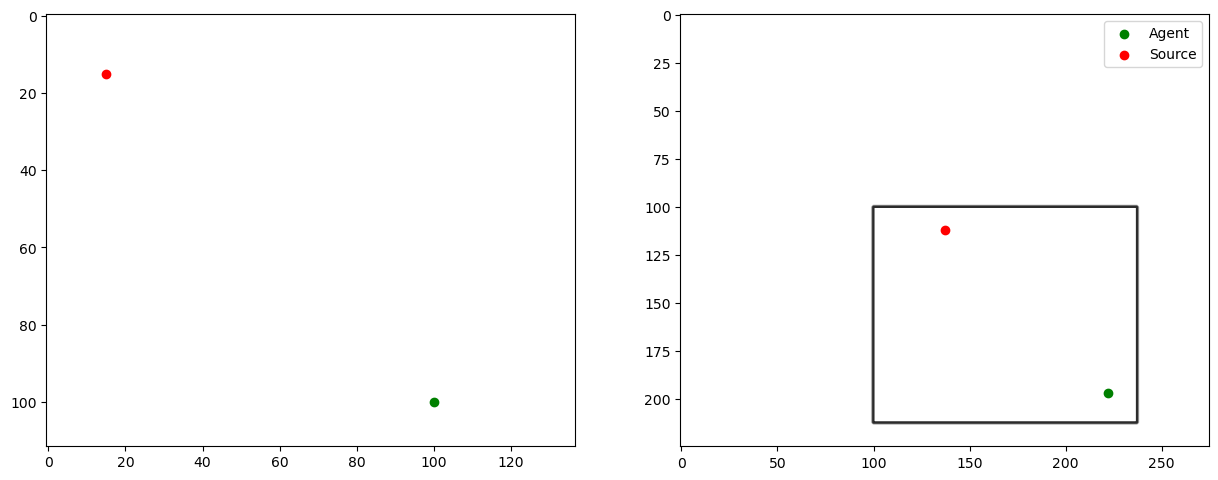

In [38]:
# PHYSICAL SPACE
# source_point = (np.random.random(2) * tank_size).astype(int)
# agent_start = (np.random.random(2) * tank_size).astype(int)

source_point = files_source_positions[file_used]
agent_start = np.array([100, 100])

print(f'Source {source_point}')
print(f'Agent {agent_start}')

fig, (ax0,ax1) = plt.subplots(ncols=2, figsize=(15,10))

ax0.imshow(np.zeros(tank_size), cmap='Greys')
ax0.scatter(source_point[1], source_point[0], c='red', label='Source')
ax0.scatter(agent_start[1], agent_start[0], c='green', label='Agent')

# STATE SPACE
center_state = agent_start
agent_start_state = center_state + (tank_size - source_point)

belief = np.zeros(env_shape)
belief[center_state[0]:center_state[0]+tank_size[0]+1, center_state[1]:center_state[1]+tank_size[1]+1] = 1
belief /= np.sum(belief)

ax1.imshow(np.zeros(env_shape), cmap='Greys')
ax1.contour(belief, cmap='Greys')
# ax1.invert_yaxis()
ax1.scatter(agent_start_state[1], agent_start_state[0], c='green', label='Agent')
ax1.scatter(tank_size[1], tank_size[0], c='red', label='Source')
ax1.legend()

In [39]:
agent_start_flat = (env_shape[1] * agent_start_state[0]) + agent_start_state[1]

a = Agent(model, fsvi_solution)
hist = a.simulate(RealSimulation(model, folder_name+files[0]), start_state=agent_start_flat, initial_belief=Belief(model, belief.flatten()), max_steps=600)

  0%|          | 0/600 [00:00<?, ?it/s]

Simulation done:
	- Runtime (s): 0.820465
	- Steps: 301
	- Total rewards: 1.0
	- End state: s_112_137


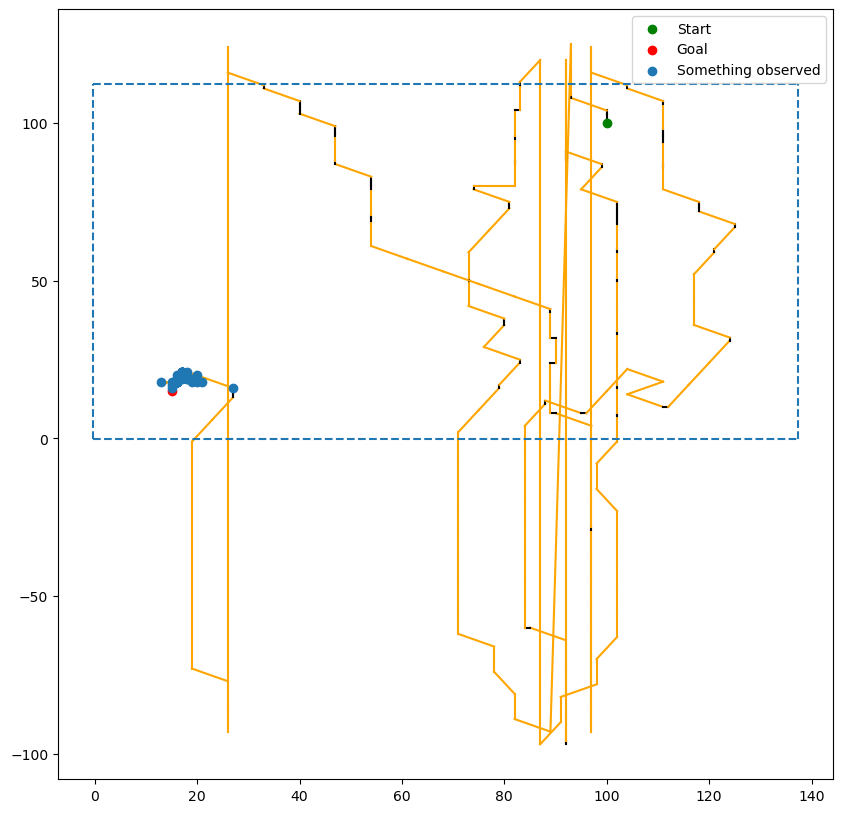

In [40]:
fig, ax = plt.subplots(figsize=(10,10))

# Initial clearing
ax.clear()

# Get cpu model
model = hist.model.cpu_model

# Plot setup
env_shape = model.cpu_model.state_grid.shape
# ax.set_xlim(0, tank_size[1])
# ax.set_ylim(tank_size[0], 0)

# Compute shift
shift = (hist.grid_point_sequence[0] - agent_start)

# Start
start_coord = hist.grid_point_sequence[0] - shift
ax.scatter(start_coord[1], start_coord[0], c='green', label='Start')

# Goal
goal_coord = source_point[None,:]
ax.scatter(goal_coord[:,1], goal_coord[:,0], c='red', label='Goal')

# Until step
seq = np.array(hist.grid_point_sequence) - shift[None,:]
seq_a = (np.array(hist.actions) < 4)

# Path
for i in range(len(seq)-1):
    ax.plot(seq[i:i+2,1], seq[i:i+2,0], c=('black' if seq_a[i] else 'orange'), zorder=-1)#, label=('Walk' if seq_a[i] else 'Swim'))

# ax.plot(seq[:,1], seq[:,0], zorder=-1, c='black', label='Path')

# Something sensed
something_obs_id = model.observation_labels.index('something')
obs_ts = np.where(np.array(hist.observations[:]) == something_obs_id)
points_obs = seq[obs_ts[0],:]
ax.scatter(points_obs[:,1], points_obs[:,0], zorder=1, label='Something observed')

# Generate legend
ax.legend()
ax.hlines([-0.3,tank_size[0]+0.3], xmin=-0.3, xmax=tank_size[1]+0.3, linestyles='dashed')
ax.vlines([-0.3,tank_size[1]+0.3], ymin=-0.3, ymax=tank_size[0]+0.3, linestyles='dashed')

## Multiple Simulations

In [95]:
np.array([*np.unravel_index([10,12,13], env_shape)]).T

array([[ 0, 10],
       [ 0, 12],
       [ 0, 13]])

In [100]:
class RealSimulationSet(SimulationSet):
    def __init__(self, model: Model, file:str) -> None:
        self.iter = None
        super().__init__(model)

        self.real_data = h5py.File(file,'r')


    def initialize_simulations(self, n, start_state) -> np.ndarray:
        self.iter = 0
        return super().initialize_simulations(n, start_state)


    def run_actions(self, actions:np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        r,_ = super().run_actions(actions)

        # GPU support
        xp = np if not self.model.is_on_gpu else cp

        # pos = self.model.get_coords(self.agent_states)
        positions = xp.array([*xp.unravel_index(self.agent_states, env_shape)]).T
        shifted_positions = positions - (xp.array(tank_size) - xp.array(source_position))[None,:]
        are_positions_in_tank = xp.all((shifted_positions >= 0) & (shifted_positions < xp.array(tank_size[None,:])), axis=1)
        positions_in_tank = shifted_positions[are_positions_in_tank, :]

        actions_of_pos_in_tank = actions[are_positions_in_tank]

        resized_ground = xp.array(cv2.resize(np.array(self.real_data[file_datasets['ground']][str(self.iter)]), resized_shape[::-1]))
        resized_air = xp.array(cv2.resize(np.array(self.real_data[file_datasets['air']][str(self.iter)]), resized_shape[::-1]))

        o = xp.ones(len(positions), dtype=int)
        o[are_positions_in_tank] = xp.where(xp.where(actions_of_pos_in_tank < 4,
                                                     resized_ground[positions_in_tank[:,0], positions_in_tank[:,1]],
                                                     resized_air[positions_in_tank[:,0], positions_in_tank[:,1]]) >= threshold, 0, 1)

        self.iter += 1
        return (r,o)

In [70]:
point_steps = 5

tank_points = np.array([x.flatten() for x in np.meshgrid(np.arange(tank_size[0])[::point_steps], np.arange(tank_size[1])[::point_steps], indexing='xy')]).T
tank_points = tank_points[np.any(tank_points != source_point[None,:], axis=1)]

print(f'Points: {len(tank_points)}')

Points: 643


In [71]:
tank_point_indices = np.ravel_multi_index((tank_points + (tank_size - source_point)[None,:]).T, dims=env_shape)

In [74]:
def beliefs_from_points(points:np.ndarray):    
    belief_list = []
    for center_state in points: 
        belief = np.zeros(env_shape)
        belief[center_state[0]:center_state[0]+tank_size[0]+1, center_state[1]:center_state[1]+tank_size[1]+1] = 1
        belief /= np.sum(belief)

        belief_list.append(belief)

    return belief_list

In [75]:
initial_beliefs = beliefs_from_points(tank_points)

In [62]:
model = model.gpu_model
value_function = fsvi_solution.to_gpu()

In [78]:
initial_beliefs[0].shape

(225, 275)

In [102]:
a = Agent(model, value_function)
_, all_sim_hist = a.run_n_simulations_parallel(len(tank_point_indices),
                                               simulator_set=RealSimulationSet(model, folder_name+files[0]),
                                               max_steps=600,
                                               start_states=tank_point_indices.tolist(),
                                               initial_beliefs=[Belief(model=model, values=b.ravel()) for b in initial_beliefs],
                                               print_progress=True)

  0%|          | 0/600 [00:00<?, ?it/s]

All 643 simulations done in 40.614s:
	- Simulations reached goal: 397/643 (246 failures)
	- Average step count: 433.04821150855366
	- Average total rewards: 0.6174183514774495
	- Average discounted rewards (ADR): 0.03381954435741039
